In [1]:
import time
import numpy as np
import ray
import kernelml 
import datetime
import pandas as pd

run_once = False
if run_once==False:
    ray.init(num_cpus = 4)
    run_once=True

@ray.remote
def no_work(a):
    return

start = time.time()
# result_ids = [no_work.remote(a_id) for x in range(10)]
# results = ray.get(result_ids)
# print("duration =", time.time() - start)

2021-10-06 17:10:56,965	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265


In [128]:
pd.read_csv('stock_train.csv').columns

Index(['sym', 'time', 'open', 'high', 'low', 'close', 'volume', 'source',
       '__index_level_0__', 'year', 'month', 'day', 'prev_close',
       'close_per_diff', 'prev_close_lag_1', 'prev_close_lag_2',
       'prev_close_lag_23', 'prev_close_lag_55', 'prev_close_lag_111',
       'prev_close_lag_166', 'per_chng_1hr', 'per_chng_2hr', 'per_chng_1dy',
       'per_chng_1wk', 'per_chng_2wk', 'per_chng_3wk', 'max_per_chng_1wk',
       'min_per_chng_1wk', 'max_per_chng_2wk', 'min_per_chng_2wk',
       'max_per_chng_3wk', 'min_per_chng_3wk', 'gnews_sentiment_3dy',
       'gnews_text_result', 'gnews_mu', 'gnews_dev', 'twitter_sentiment_3dy',
       'tweet_text_result', 'twitter_mu', 'twitter_dev'],
      dtype='object')

In [134]:
number_of_lags = 10

lag_arr = []

sym = ['nvda','wmt','dash']

qry_string = ",".join([s.lower() for s in sym])

count=0
df = pd.DataFrame()
for s in sym[:]:

    tmp = pd.read_csv('stock_train.csv')
    tmp = tmp[tmp.sym==s][['sym','close', 'twitter_sentiment_3dy','gnews_sentiment_3dy','time']]

    if len(tmp)==0:
        print(s+' is empty')
        continue


    tmp = tmp.set_index('time')

#     tmp.index = [datetime.datetime.strptime(t,"%Y-%m-%d") for t in tmp.index]
    tmp.index = [datetime.datetime.strptime(t,"%Y-%m-%d %H:%M:%S") for t in tmp.index]
    
    tmp.columns = [s+'_'+c for c in tmp.columns]
    
    if count==0:
        df = tmp
    else:
        df = df.merge(tmp,left_index=True,right_index=True,how='outer')
    count+=1

In [143]:
def percent_change_variable(x):
    z = np.zeros(x.shape[:])
    z[0]=0
    for t in range(len(x)):
        if t>=1:
            z[t]=(x[t]-x[t-1])/(np.abs(x[t-1])+1e-6)
    return z[:]

In [180]:
#define features and target
features = ['nvda_close','nvda_twitter_sentiment_3dy','nvda_gnews_sentiment_3dy']
tar = 'nvda'
tar_close = tar+'_close'
target_close_td = tar_close+'_td'

close = df[tar_close].values
#create %change in target
close_per_chng = percent_change_variable(close)
df[target_close_td] = close_per_chng
    

In [181]:
from model.spiking_network import SpikingNetwork
from model.spiking_network import AutoRegressiveLayer, SparseSpikingLayer, HiddenLayer, Feedback

In [203]:
number_of_lags = 10


X = df[features].values

y = df[[target_close_td]].fillna(0).values.ravel()

graph = SpikingNetwork()

lag_arr = graph.lagValues(X,y,input_size=10,output_size=3,
                                         l1_regularization=0.0)

graph.spikingSparseComponents(X,y,input_size=10,output_size=10,
                                         l1_regularization=0.0)


graph.hiddenComponents(input_size=10,output_size=1,
                      l1_regularization=1.0)

error_lag = 1
# graph.feedbackComponents(window_size=error_lag,
#                         l1_regularization=1.0)


# graph.movingAverage(l1_regularization=1e-3)

print('lags:',lag_arr)

lag_arr = lag_arr

model_shapes = graph.model_shapes

max_lag = np.max(lag_arr)
min_lag = np.min(lag_arr)
N = graph.number_of_parameters
num_parameters = N

print('number of parameters:',N)

function_list = graph.forward_list
layer_num_list = graph._layer_numbers
regularization_list = graph._l1_regularization
layer_num_list = np.array(layer_num_list)

print(model_shapes)
print(function_list)
print(layer_num_list)
print(regularization_list)
print(np.sum([np.prod(x) for x in model_shapes]))

lags: [[ 8 12  7]
 [ 5  1 15]
 [ 9 13  8]
 [ 7 15 17]
 [ 2 16 12]
 [17 14 13]
 [ 1 17 16]
 [20 19 19]
 [19 20 20]
 [18 18 18]]
number of parameters: 311
[(10, 10), (10, 10), (10, 10), (10, 1), (1, 1)]
['sparse_spike', 'hidden']
[0 0 0 1 1]
[0.0, 0.0, 0.0, 1.0, 0]
311


In [310]:
def reshape_function(w,model_shapes):
    np=numpy
    reshape_w = []
    indx = 0
    for shape in model_shapes:
        num = np.prod(shape)
        x = w[indx:num+indx]
        if x.size!=num:
            continue
        x = x.reshape(shape)
        reshape_w.append(x)
        indx = indx+num
    extra_w = w[indx:].reshape(-1,1)
    return np.array(reshape_w)


import numpy
def spiking_function(x,y,w,args,predict=False):
    np=numpy
    
    model_shapes = args[0]
    lag_arr = args[1]
    function_list = args[2]
    layer_num_list= args[3]
    error_lag = args[4]
    regularization_list = args[5]
    
    max_lag = np.max(lag_arr)
    min_lag = np.min(lag_arr)

    w_tensor = reshape_function(w,model_shapes)

    predictions = np.zeros((y.shape[0]+min_lag,1))

    predictions[:max_lag] = y[:max_lag,0:1]
    mask = max_lag-lag_arr
    error = predictions[max_lag-error_lag:max_lag,0:1] - x[max_lag-error_lag:max_lag,0:1]
    
    membrane = np.zeros((1,10))
    
    for i in range(max_lag,y.shape[0]+min_lag):
        fcount = 0 
        
        
        for func in function_list:
            w = w_tensor[layer_num_list==fcount]
            if func=='ar':
                pred = AutoRegressiveLayer(x[i-max_lag:i],w,lag_arr)
            if func=='sparse_spike':
                pred,membrane = SparseSpikingLayer(x[i-max_lag:i],w,lag_arr,membrane)
            elif func=='feed':
                pred = Feedback(pred,error,w)
            elif func=='hidden':
                pred = HiddenLayer(pred,w)
            fcount+=1
    
        predictions[i] = pred
        if i<y.shape[0]:
            error = y[i-error_lag-min_lag:i-min_lag,0:1] - predictions[i-error_lag-min_lag:i-min_lag,0:1]

    if predict==True:
        return predictions

    regularizer = [r*np.sum(np.abs(w)) for r,w in zip(regularization_list,w_tensor)]

    a = y[max_lag:,0]
    b = predictions[max_lag:-min_lag,0]

    fp = np.sum((b>=0)&(a<0))
    fn = np.sum((b<0)&(a>=0))

    mae = (fp+fn)#+np.mean(np.abs(a-b)**2)

    return mae+np.sum(regularizer)



In [311]:
X = df[features].apply(lambda x: percent_change_variable(x.values),axis=0).values

norm = np.linalg.norm(X,axis=0)
# X = X/norm
y = df[[target_close_td]].fillna(0).values.reshape(-1,1)


args=np.array([model_shapes,
               lag_arr,
               function_list,
               layer_num_list,
               error_lag,
               regularization_list], dtype="object")
              


args_id = ray.put(args)

@ray.remote
def map_losses(X,y,w_list,w_indx,args):
    N = w_indx.shape[0]
    resX = np.zeros(N)
    iter_ = 0
    for i in w_indx:
        loss = spiking_function(X,y,w_list[:,i:i+1],args)
        resX[iter_] = loss
        iter_+=1
    return resX
    

def ray_parallel_mapper(X,y,w_list,args):
    
    num_cores = 4
    
    weights_index = np.arange(0,w_list.shape[1])
    weights_index_split = np.array_split(weights_index,num_cores)
    
    w_list_id = ray.put(w_list)
    
    result_ids = [map_losses.remote(X_id,y_id,w_list_id,weights_index_split[i],args_id) for i in range(4)]
    result = ray.get(result_ids)
    
    loss = []
    indx = []
    for l in result:
        loss.extend(l)
    loss = np.hstack(loss)
    return loss

from math import gamma

def posterior_sampler_uniform_distribution(kmldata):

    random_samples = kmldata.prior_random_samples
    variances = np.var(kmldata.update_history[:,:],axis=1).flatten()
    means = kmldata.best_weight_vector.flatten()

    return np.vstack([np.random.normal(mu,sigma/2,(random_samples)) for sigma,mu in zip(variances,means)])

#take a sequential window of data 
def mini_batch_random_window(X,y,batch_size):
    W = batch_size//2
    center = np.random.randint(W,X.shape[0]-W)
    X_batch = X[center-W:center+W]
    y_batch = y[center-W:center+W]
    return X_batch,y_batch




In [312]:
import matplotlib.pyplot as plt

In [313]:
import kernelml 

num_parameters = N
batchsize=100
test_size=8*4
 

#optimizer parameters
zscore=2.0
realizations = 4
cycles = 10
volume = 10
simulations = 10*np.int(num_parameters)
volatility = 1

X_train,y_train = X[:-test_size],y[:-test_size]

X_id = ray.put(X_train)
y_id = ray.put(y_train)

In [314]:
p_by_r_sim = []
for _ in range(4):
        


        
        kml0 = kernelml.KernelML(ray_parallel_mapper,
                         prior_sampler_fcn=None,
                         posterior_sampler_fcn=None,
                         intermediate_sampler_fcn=None,
                         parameter_transform_fcn=None,
                         batch_size=None)

        kml0.optimize(X_train,y_train,
                                        number_of_parameters=np.int(num_parameters),
                                        args=[args],
                                        number_of_realizations=realizations,
                                        number_of_random_simulations =simulations,
                                        update_volatility = volatility,
                                        number_of_cycles=cycles,
                                        update_volume=volume,
                                        convergence_z_score=zscore,
                                        prior_uniform_low=-1e-9,
                                        prior_uniform_high=1e-9,
                                        print_feedback=True)

        kmldata0 = kml0.kmldata
        
        parameter_by_run_ = kml0.kmldata.update_by_realization[-1:,:]
        p_by_r_sim.append(parameter_by_run_)

(pid=34284) <ipython-input-310-0a552b63bc07>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
(pid=23432) <ipython-input-310-0a552b63bc07>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
(pid=40860) <ipython-input-310-0a552b63bc07>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
(pid=2620) <ipython-input-310-0a552b63bc07>:14: Visible

realization 0 loss 82.00000001279277 time 153.13056707382202
realization 1 loss 84.0000000190179 time 154.6940052509308
realization 2 loss 78.00000001747114 time 152.07735800743103
realization 3 loss 70.00000001783395 time 153.08064126968384
realization 0 loss 79.00000001865284 time 153.46758723258972
realization 1 loss 74.00000001727621 time 154.07744526863098
realization 2 loss 73.00000001986176 time 159.8429455757141
realization 3 loss 67.00000001981604 time 163.66522908210754
realization 0 loss 86.00000000522137 time 157.94176840782166
realization 1 loss 83.00000000800274 time 153.5535500049591
realization 2 loss 82.00000000945157 time 153.65969920158386
realization 3 loss 75.00000000827721 time 157.59445786476135
realization 0 loss 84.00000001599541 time 155.08416295051575
realization 1 loss 81.00000001591194 time 152.77174878120422
realization 2 loss 76.00000001681366 time 150.51946473121643
realization 3 loss 77.00000001345525 time 153.12067437171936


In [315]:
parameter_by_run_ = np.vstack(p_by_r_sim)

F_train = np.zeros((y_train.shape[0],parameter_by_run_.shape[0]))
for i in range(parameter_by_run_.shape[0]):
    w = parameter_by_run_[i]
    F_train[:,i] = spiking_function(X_train,y_train,w,args=args,predict=True).flatten()[:-min_lag]
    
from sklearn import linear_model

In [316]:
LR = linear_model.LinearRegression()
LR.fit(F_train,y_train)
LR.coef_

array([[  674413.84354359,   413525.15708092, -1092002.79012705,
            4064.7914719 ]])

In [317]:
parameter_by_run_ = np.vstack(p_by_r_sim)


forecasts = np.zeros((y.shape[0]+min_lag,parameter_by_run_.shape[0]))
for i in range(parameter_by_run_.shape[0]):
    w = parameter_by_run_[i]
    forecasts[:,i] = spiking_function(X,y,w,args=args,predict=True).flatten()
    
# y_pred = np.mean(forecasts,axis=1)*1e6
y_pred = LR.predict(forecasts).flatten()

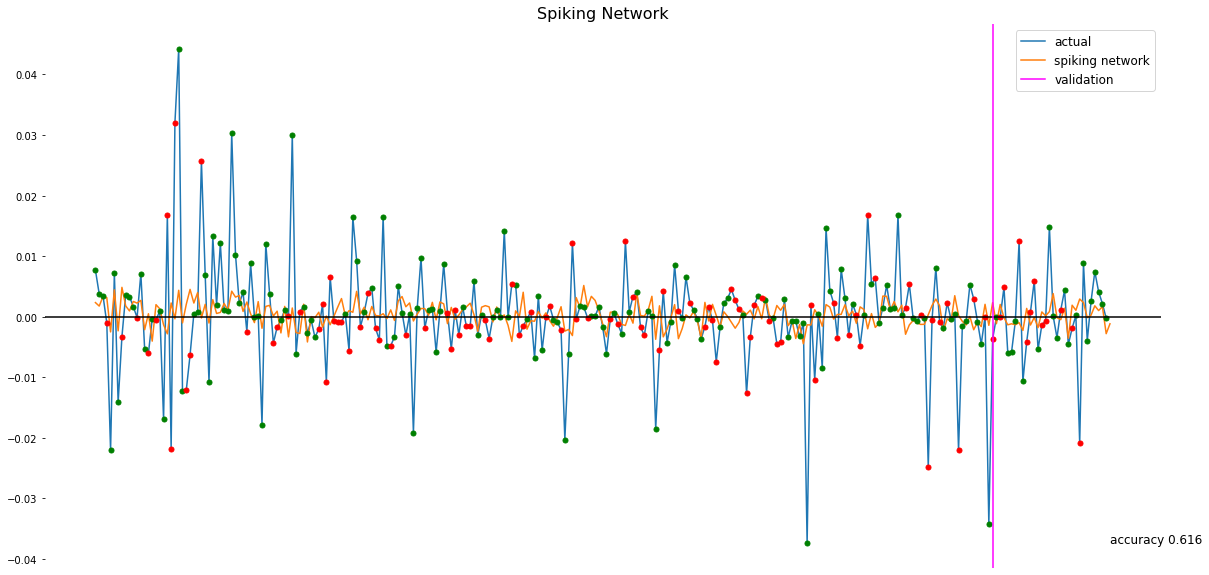

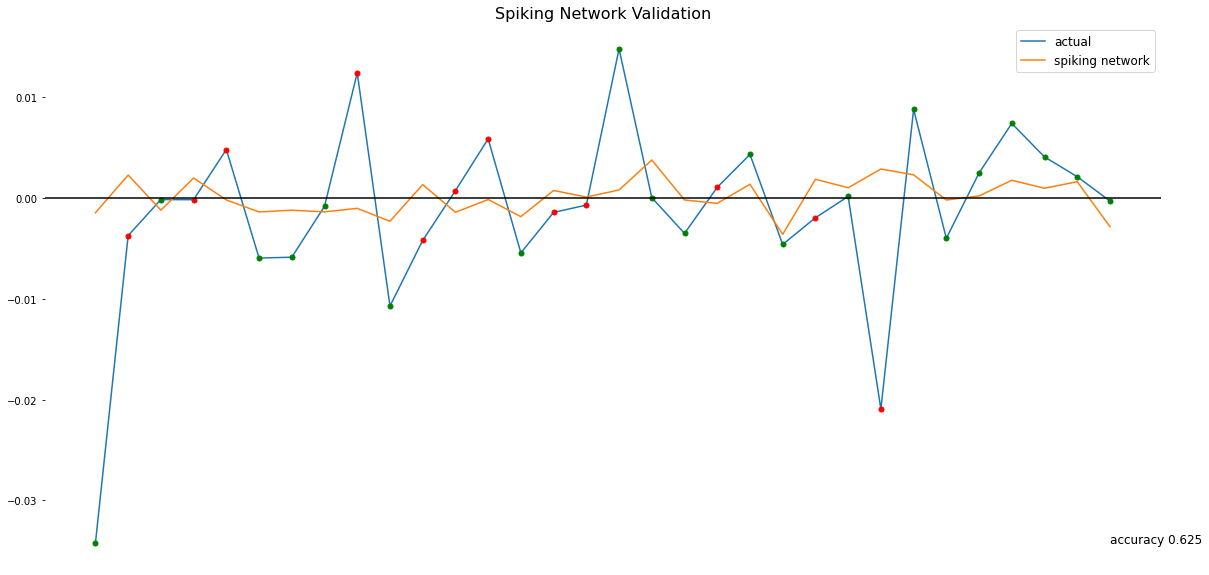

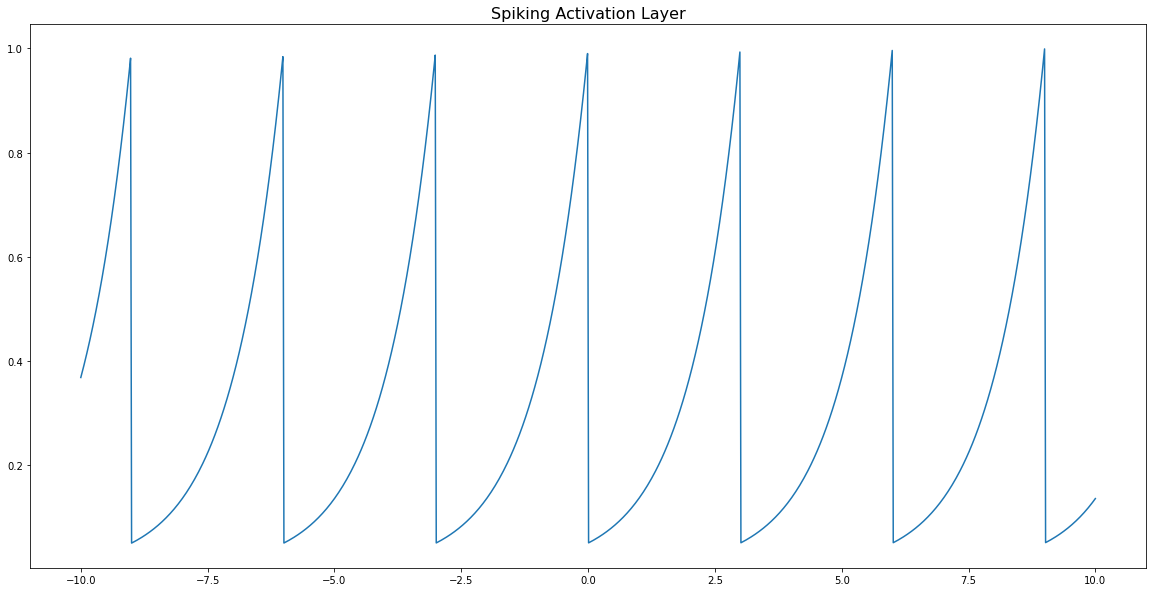

In [319]:
import matplotlib.pyplot as plt
t = np.concatenate([df.index[max_lag:],df.index[-1:]+datetime.timedelta(hours=1)]).astype(str)

plt.figure(figsize=(20,10))


#these variables are used for comparisons
b=y_pred[max_lag:-1]
a=y.flatten()[max_lag:]

fp = np.sum((b>=0)&(a<0))
tp = np.sum((b>=0)&(a>=0))
fn = np.sum((b<0)&(a>=0))
tn = np.sum((b<0)&(a<0))
tpr = np.round((tp)/(tp+fn),3)
tnr = np.round((tn)/(tn+fp),3)
acc = np.round((tp+tn)/(tp+tn+fp+fn),3)

plt.plot(t[:-1],y[max_lag:],label='actual')
plt.plot(t,y_pred[max_lag:],label='spiking network')

# plt.plot(t[:-1][(b>0)&(a>0)],a[(b>0)&(a>0)],'g.',markersize=10)
# plt.plot(t[:-1][(b<=0)&(a<=0)],a[(b<=0)&(a<=0)],'r.',markersize=10)

plt.plot(t[:-1][(b>0)==(a>0)],a[(b>0)==(a>0)],'g.',markersize=10)
plt.plot(t[:-1][(b<=0)!=(a<=0)],a[(b<=0)!=(a<=0)],'r.',markersize=10)

plt.text(t[-1],np.min(a),'accuracy {}'.format(acc),fontsize=12)

plt.axhline(y=0,color='black')   
plt.axvline(t[-test_size],color='magenta',label='validation')

plt.title('Spiking Network',fontsize=16)
plt.box(False)
plt.xticks([])
plt.legend( prop={'size': 12})

plt.show()

plt.figure(figsize=(20,10))

b=y_pred[max_lag:-min_lag][-test_size:]
a=y.flatten()[max_lag:][-test_size:]
t=t[-test_size-min_lag:-min_lag]

fp = np.sum((b>=0)&(a<0))
tp = np.sum((b>=0)&(a>=0))
fn = np.sum((b<0)&(a>=0))
tn = np.sum((b<0)&(a<0))
tpr = np.round((tp)/(tp+fn),3)
tnr = np.round((tn)/(tn+fp),3)
acc = np.round((tp+tn)/(tp+tn+fp+fn),3)

plt.plot(t,a,label='actual')
plt.plot(t,b,label='spiking network')

plt.plot(t[(b>0)==(a>0)],a[(b>0)==(a>0)],'g.',markersize=10)
plt.plot(t[(b<=0)!=(a<=0)],a[(b<=0)!=(a<=0)],'r.',markersize=10)

plt.axhline(y=0,color='black')  

plt.text(t[-1],np.min(a),'accuracy {}'.format(acc),fontsize=12)

plt.title('Spiking Network Validation',fontsize=16)
plt.box(False)
plt.xticks([])
plt.legend( prop={'size': 12})

plt.show()

plt.figure(figsize=(20,10))
plt.title('Spiking Activation Layer',fontsize=16)
t = np.linspace(-10,10,1000)
spike = np.exp(-(-t % 3))
plt.plot(t,spike)
plt.show()